In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
# Have to install TensorFlow 2.0 with new session (but not each new runtime)
# !pip install tensorflow=="2.0.0"
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from keras.utils import np_utils

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

print(tf.__version__)

1.15.0


In [0]:
# Download data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


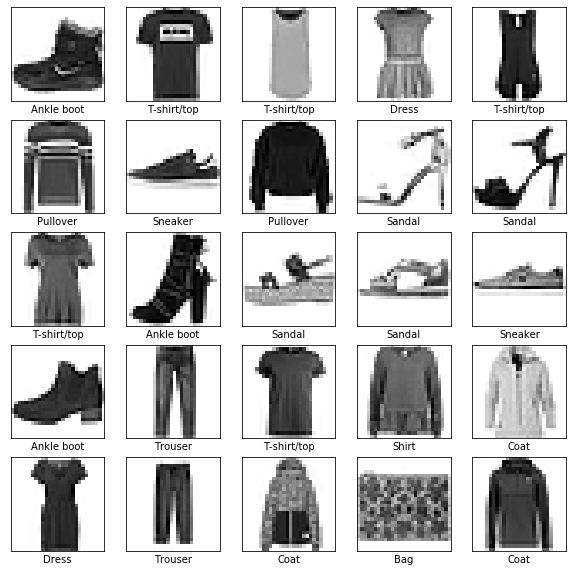

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [0]:
# Data prep
# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

(60000, 28, 28, 1)

In [0]:
# TensorFlow/Keras Model
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb?fbclid=IwAR070qdCr-MYoVJs0ovnv8nQCta5-GNzEfXgj_sXl31T53PPjRc5nGLh-w0#scrollTo=pWEYmd_hIWg8
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

In [0]:
# Initialize TPUs
import os
tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver) 
tf.compat.v1.disable_eager_execution()

INFO:tensorflow:Initializing the TPU system: 10.7.199.194:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorfl

In [0]:
with strategy.scope():
  keras_model = create_model()
  keras_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

In [0]:
# Send model to TPUs
t1 = time.time()
keras_model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs = 20,
    steps_per_epoch = 1500,
    # steps_per_epoch = 60, for some reason it crashes if I don't specify steps_per_epoch or if steps = nrow(train)/epochs
    validation_data = (x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq = 1
)
t2 = time.time()
# We can save our model with: not sure where it is going
keras_model.save('model.h5')
# and reload it with:
# keras_model = tf.keras.models.load_model('model.h5')
train_time = t2 - t1

Epoch 1/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7892 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8757
Epoch 2/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.3942 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.3295 - val_sparse_categorical_accuracy: 0.8898
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.3190 - val_sparse_categorical_accuracy: 0.8836
Epoch 4/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.3286 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.2983 - val_sparse_categorical_accuracy: 0.8958
Epoch 5/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3095 - sparse_categorical_accuracy: 0.8898 - val_loss: 0.2898 - val_sparse_categorical_accuracy: 0.9027
Epoch 6/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.

In [0]:
print(keras_model.summary())
print(train_time)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
conv2d (Conv2D)              multiple                  1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0

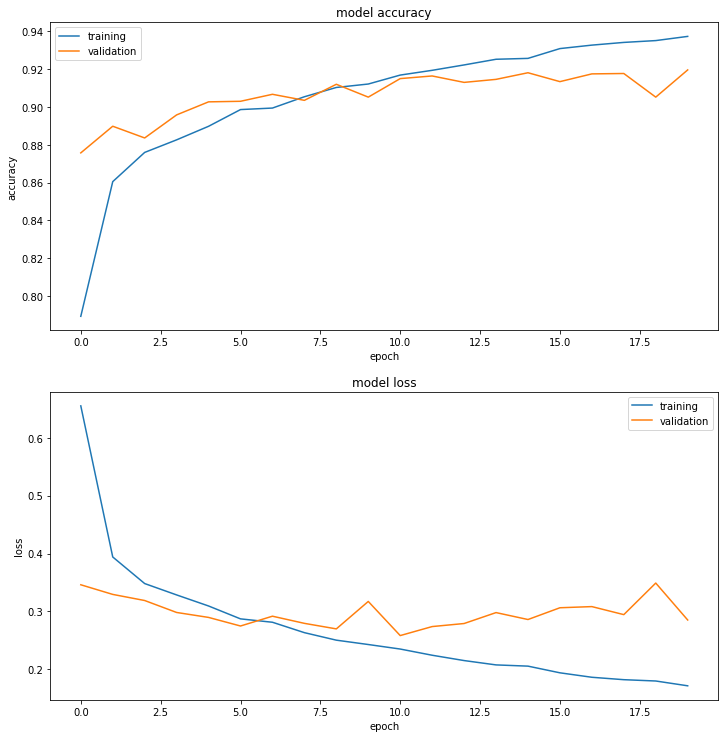

In [0]:
def training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
training_curves(keras_model.history.history['sparse_categorical_accuracy'], 
                        keras_model.history.history['val_sparse_categorical_accuracy'], 'accuracy', 211)
training_curves(keras_model.history.history['loss'], 
                        keras_model.history.history['val_loss'], 'loss', 212)

In [0]:
# https://gist.github.com/yufengg/2b2fd4b81b72f0f9c7b710fa87077145
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

x_train_flat = np.array(x_train).reshape((-1, 28*28))
x_test_flat = np.array(x_test).reshape((-1, 28*28))
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train_flat, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = regr.predict(x_test_flat).round(0)

In [0]:
accuracy_score(y_test, y_pred)

0.3688

In [0]:
r2_score(y_test, y_pred)

0.7518424242424242

In [0]:
y_pred.min()

-2.0